# Benchmarking Location Privacy
#### Franklin Harvey

## Question
With regards to privacy I wanted to answer the question "Is it better to truncate the precision of a geospatial point, or to randomly move that point to a nearby location?"

With both approaches we can define how far we would like to move a point. By truncating to 2 decimal places we likely move a point nearly 1km. By fuzzing we can define a radius in which to replace the point, so it will move by at-most that radius.


## Obfuscation
How do we define obfuscation? What is a "good" level of obfuscation and what is a "bad" level.

A good level of obfuscation could loosely be defined as "this location is not the original location". Put from a user's perspective: "This dot that represents me is not at my house".

Our legal department has defined **1km** as a good distance away. So I'll use this definition:

*A good level of obfuscation is for a point to be a kilometer away from its original location*

In [117]:
from random import randrange, random
from math import radians, cos, sin, pi, sqrt, atan2, trunc, floor
import statistics
from geopy.distance import distance

def h_getFuzzedLocation(latLng, radius, roundDecimals = 5):
    lat = latLng[0]
    lng = latLng[1]
    radiusInDegrees = radius / 111000
    
    u = random()
    v = random()
    
    w = radiusInDegrees * sqrt(u)
    t = 2 * pi * v
    x = w * cos(t)
    y = w * sin(t)

    new_x = x / cos(radians(lat))

    foundLongitude = round(new_x + lng, roundDecimals)
    foundLatitude = round(y + lat, roundDecimals)
    coords = wrap(foundLatitude, foundLongitude)
    return [coords["lat"], coords["lon"]]

def fuzz(distance):
    return lambda x: h_getFuzzedLocation(x, distance)


# https://gist.github.com/missinglink/d0a085188a8eab2ca66db385bb7c023a
def wrap( lat, lon ):
    point = { "lat": lat, "lon": lon }
    quadrant = floor( abs( lat ) / 90) % 4
    pole = 90 if lat > 0 else -90
    offset = lat - trunc(lat/90) * 90 # TIL modulo is different in python than JS

    if quadrant == 0:
        point["lat"] = offset
    elif quadrant == 1:
        point["lat"] = pole - offset
        point["lon"] += 180
    elif quadrant == 2:
        point["lat"] = -1 * offset
        point["lon"] += 180
    elif quadrant == 3:
        point["lat"] = (-1 * pole) + offset

    if point["lon"] > 180 or point["lon"] < -180:
        point["lon"] -= floor(( point["lon"] + 180 ) / 360) * 360

    return point

assert wrap(55.555, 22.222) == {"lat": 55.555, "lon": 22.222}

assert wrap(1, 0) == {"lat": 1, "lon": 0}
assert wrap(91, 0) == {"lat": 89, "lon": 180}
assert wrap(181, 0) == {"lat": -1, "lon": 180}
assert wrap(271, 0) == {"lat": -89, "lon": 0}
assert wrap(361, 0) == {"lat": 1, "lon": 0}
assert wrap(631, 0) == {"lat": -89, "lon": 0}
assert wrap(721, 0) == {"lat": 1, "lon": 0}

assert wrap(-1, 0) == {"lat": -1, "lon": 0}
assert wrap(-91, 0) == {"lat": -89, "lon": 180}
assert wrap(-181, 0) == {"lat": 1, "lon": 180}
assert wrap(-271, 0) == {"lat": 89, "lon": 0}
assert wrap(-361, 0) == {"lat": -1, "lon": 0}
assert wrap(-631, 0) == {"lat": 89, "lon": 0}
assert wrap(721, 0) == {"lat": 1, "lon": 0}

assert wrap(0, 1) == {"lat": 0, "lon": 1}
assert wrap(0, 181) == {"lat": 0, "lon": -179}
assert wrap(0, 271) == {"lat": 0, "lon": -89}
assert wrap(0, 361) == {"lat": 0, "lon": 1}
assert wrap(0, 631) == {"lat": 0, "lon": -89}
assert wrap(0, 721) == {"lat": 0, "lon": 1}

assert wrap(0, -1) == {"lat": 0, "lon": -1}
assert wrap(0, -181) == {"lat": 0, "lon": 179}
assert wrap(0, -271) == {"lat": 0, "lon": 89}
assert wrap(0, -361) == {"lat": 0, "lon": -1}
assert wrap(0, -631) == {"lat": 0, "lon": 89}
assert wrap(0, -721) == {"lat": 0, "lon": -1}

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [118]:
def getRandomCoordinate(minLat = -90, minLong = -180, maxLat = 90, maxLong = 180):
    lat = randrange(minLat, maxLat)
    lat = round(lat + random(), 5)
    long = randrange(minLong, maxLong)
    long = round(long + random(), 5)
    return [lat, long]

def getDistanceInKM(point1, point2):
    return distance(point1, point2).km

assert getDistanceInKM([40, -105], [0,0]) == 11286.326422073269
assert getDistanceInKM([0, 0], [0,0]) == 0

## Fuzzing Once

In [119]:
fuzzOneRandomCoords = [getRandomCoordinate() for n in range(100000)]
fuzzOneFuzzedCoords = list(map(fuzz(1500), fuzzOneRandomCoords))
fuzzOneDistances = []
for i in range(len(fuzzOneFuzzedCoords)):
    fuzzOneDistances.append(getDistanceInKM(fuzzOneFuzzedCoords[i], fuzzOneRandomCoords[i]))

print("Mean distance (m): " + str(statistics.mean(fuzzOneDistances) * 1000))
print("Minimum distance (m): " + str(min(fuzzOneDistances) * 1000))
print(color.BOLD + color.GREEN + "Std. Dev (m): " + str(statistics.stdev(fuzzOneDistances) * 1000) + color.END)

Mean distance (m): 1003.6238810894358
Minimum distance (m): 3.317921428670807
Std. Dev (m): 353.79806991862193


If we fuzz with a radius of 1500 meters we can expect an average distance of **1km** with a standard deviation of **~354m**.

My next question is what is better, to fuzz once with a large radius, or to fuzz many times with a small radius? Keep in mind that as you fuzz many times you start to emulate a [random walk](https://en.wikipedia.org/wiki/Random_walk) algorithm. This is not exactly what we want as it is computationally expensive. We are after final random points, not their journeys.

## Fuzzing 300 times

In [120]:
fuzzManyRandomCoords = [getRandomCoordinate() for n in range(100000)]
numberOfFuzzing = 300
fuzzManyFuzzedCoords = fuzzManyRandomCoords.copy()
for i in range(numberOfFuzzing):
    fuzzManyFuzzedCoords = list(map(fuzz(100), fuzzManyFuzzedCoords)).copy()

fuzzManyDistances = []
for i in range(len(fuzzManyFuzzedCoords)):
    fuzzManyDistances.append(getDistanceInKM(fuzzManyFuzzedCoords[i], fuzzManyRandomCoords[i]))

print("Mean distance (m): " + str(statistics.mean(fuzzManyDistances) * 1000))
print("Minimum distance (m): " + str(min(fuzzManyDistances) * 1000))
print("Std. Dev (m): " + str(statistics.stdev(fuzzManyDistances) * 1000))

Mean distance (m): 1087.4650284221862
Minimum distance (m): 2.353148807619283
Std. Dev (m): 567.1656765997614


By fuzzing by only **100m**, but doing so 300 times to every point, we get a similar level of fuzzing but with a much higher standard deviation. ~This is only running with 1/10 the number of points and is much slower~ This is **much** slower. I think this is good evidence that fuzzing once by a large radius is a better model for randomizing points than many times with a smaller radius.

## Fuzzing ~10 times

In [121]:
fuzz10TimesRandomCoords = [getRandomCoordinate() for n in range(100000)]
numberOfFuzzing = 12
fuzz10TimesFuzzedCoords = fuzz10TimesRandomCoords.copy()
for i in range(numberOfFuzzing):
    fuzz10TimesFuzzedCoords = list(map(fuzz(500), fuzz10TimesFuzzedCoords)).copy()

fuzz10TimesDistances = []
for i in range(len(fuzz10TimesFuzzedCoords)):
    fuzz10TimesDistances.append(getDistanceInKM(fuzz10TimesFuzzedCoords[i], fuzz10TimesRandomCoords[i]))

print("Mean distance (m): " + str(statistics.mean(fuzz10TimesDistances) * 1000))
print("Minimum distance (m): " + str(min(fuzz10TimesDistances) * 1000))
print("Std. Dev (m): " + str(statistics.stdev(fuzz10TimesDistances) * 1000))

Mean distance (m): 1096.6078268135834
Minimum distance (m): 2.961411226724857
Std. Dev (m): 563.606833828889


## Truncating to 2 decimal places

In [122]:
def truncatePoint(digits = 2):
    return lambda x: lambda_truncatePoint(x, digits)

def lambda_truncatePoint(point, digits):
    stepper = 10.0 ** digits
    lat = trunc(stepper * point[0]) / stepper
    long = trunc(stepper * point[1]) / stepper
    return [lat, long]

assert truncatePoint(2)([0.1134, 38.4328946792]) == [0.11, 38.43]
assert truncatePoint(1)([-0.99, -100.92]) == [-0.9, -100.9]
assert truncatePoint(1.5)([-1, 1]) == [-0.9803060746521977, 0.9803060746521977]
assert truncatePoint(-1)([11.1134, 38.4328946792]) == [10.0, 30.0]

In [123]:
truncRandomCoords = [getRandomCoordinate() for n in range(100000)]
truncFuzzedCoords = list(map(truncatePoint(2), truncRandomCoords))

truncDistances = []
for i in range(len(truncFuzzedCoords)):
    truncDistances.append(getDistanceInKM(truncFuzzedCoords[i], truncRandomCoords[i]))

print("Mean distance (m): " + str(statistics.mean(truncDistances) * 1000))
print("Minimum distance (m): " + str(min(truncDistances) * 1000))
print("Std. Dev (m): " + str(statistics.stdev(truncDistances) * 1000))

Mean distance (m): 720.3727100111274
Minimum distance (m): 1.024620183161797
Std. Dev (m): 316.0232844553472


## "Truncating" to ~1.8 decimal places
I know this is crazy but its a good approximation for how we could truncate and get close to a 1km average distance

In [124]:
truncBenchRandomCoords = [getRandomCoordinate() for n in range(100000)]
truncBenchFuzzedCoords = list(map(truncatePoint(1.85), truncBenchRandomCoords))

truncBenchDistances = []
for i in range(len(truncBenchFuzzedCoords)):
    truncBenchDistances.append(getDistanceInKM(truncBenchFuzzedCoords[i], truncBenchRandomCoords[i]))

print("Mean distance (m): " + str(statistics.mean(truncBenchDistances) * 1000))
print("Minimum distance (m): " + str(min(truncBenchDistances) * 1000))
print("Std. Dev (m): " + str(statistics.stdev(truncBenchDistances) * 1000))

Mean distance (m): 1018.7441476399115
Minimum distance (m): 3.88678228542072
Std. Dev (m): 445.7669590434057


## Looking at the data

Below are some visualizations meant to help describe what is happening with these different approaches. The key takeaways are:

- Fuzzing once does not give a uniform distribution of distances. Points are more likely to fall near the radius than at the center
- Fuzzing many times, even if as few as 10 times, gives a much more uniform distribution. This is good as it makes points less predictable, and there is less of a "hard-stop" or an outer ring to look for.
- Truncating leaves more points closer to its origin than any of the fuzzing techniques

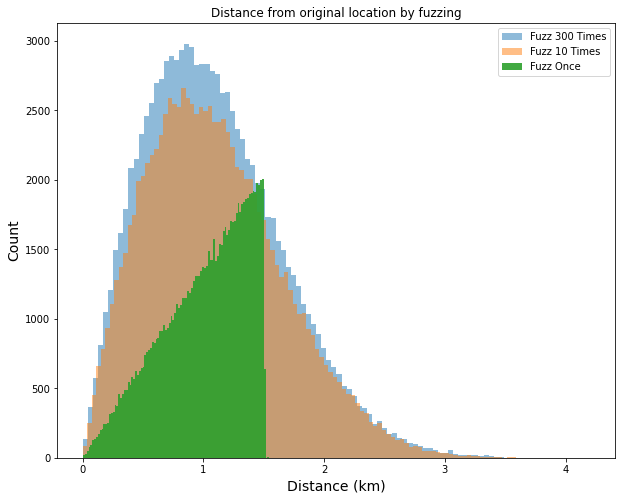

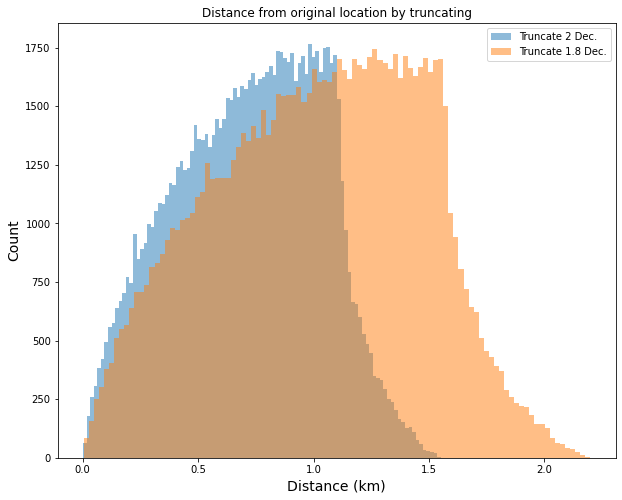

In [130]:
import matplotlib.pyplot as plt

assert len(fuzzOneDistances) == len(fuzz10TimesDistances) == len(fuzzManyDistances) == len(truncDistances) == len(truncBenchDistances)

plt.figure(figsize=(10,8))
plt.hist(fuzzManyDistances, bins=100, alpha=0.5, label="Fuzz 300 Times")
plt.hist(fuzz10TimesDistances, bins=100, alpha=0.5, label="Fuzz 10 Times")
plt.hist(fuzzOneDistances, bins=100, alpha=0.9, label="Fuzz Once")

plt.title("Distance from original location by fuzzing")
plt.xlabel("Distance (km)", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10,8))
plt.hist(truncDistances, bins=100, alpha=0.5, label="Truncate 2 Dec.")
plt.hist(truncBenchDistances, bins=100, alpha=0.5, label="Truncate 1.8 Dec.")
plt.title("Distance from original location by truncating")
plt.xlabel("Distance (km)", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

In [126]:
def lessThanDistace(distance):
    return lambda x: x*1000 < distance

print("Percent less than 100m away from original")
print("Fuzz once: ", str(len(list(filter(lessThanDistace(100), fuzzOneDistances))) / len(fuzzOneDistances) * 100), "%")
print("Fuzz 10 times: ", str(len(list(filter(lessThanDistace(100), fuzz10TimesDistances))) / len(fuzz10TimesDistances) * 100), "%")
print("Fuzz 300 times: ", str(len(list(filter(lessThanDistace(100), fuzzManyDistances))) / len(fuzzManyDistances) * 100), "%")
print("Trunc to 2 dec places: ", str(len(list(filter(lessThanDistace(100), truncDistances))) / len(truncDistances) * 100), "%")
print("Trunc to 1.8 dec places: ", str(len(list(filter(lessThanDistace(100), truncBenchDistances))) / len(truncBenchDistances) * 100), "%")
print()
print("Percent less than 300m away from original")
print("Fuzz once: ", str(len(list(filter(lessThanDistace(300), fuzzOneDistances))) / len(fuzzOneDistances) * 100), "%")
print("Fuzz 10 times: ", str(len(list(filter(lessThanDistace(300), fuzz10TimesDistances))) / len(fuzz10TimesDistances) * 100), "%")
print("Fuzz 300 times: ", str(len(list(filter(lessThanDistace(300), fuzzManyDistances))) / len(fuzzManyDistances) * 100), "%")
print("Trunc to 2 dec places: ", str(len(list(filter(lessThanDistace(300), truncDistances))) / len(truncDistances) * 100), "%")
print("Trunc to 1.8 dec places: ", str(len(list(filter(lessThanDistace(300), truncBenchDistances))) / len(truncBenchDistances) * 100), "%")
print()
print("Percent less than 500m away from original")
print("Fuzz once: ", str(len(list(filter(lessThanDistace(500), fuzzOneDistances))) / len(fuzzOneDistances) * 100), "%")
print("Fuzz 10 times: ", str(len(list(filter(lessThanDistace(500), fuzz10TimesDistances))) / len(fuzz10TimesDistances) * 100), "%")
print("Fuzz 300 times: ", str(len(list(filter(lessThanDistace(500), fuzzManyDistances))) / len(fuzzManyDistances) * 100), "%")
print("Trunc to 2 dec places: ", str(len(list(filter(lessThanDistace(500), truncDistances))) / len(truncDistances) * 100), "%")
print("Trunc to 1.8 dec places: ", str(len(list(filter(lessThanDistace(500), truncBenchDistances))) / len(truncBenchDistances) * 100), "%")
print()
print("Percent less than 1000m away from original")
print("Fuzz once: ", str(len(list(filter(lessThanDistace(1000), fuzzOneDistances))) / len(fuzzOneDistances) * 100), "%")
print("Fuzz 10 times: ", str(len(list(filter(lessThanDistace(1000), fuzz10TimesDistances))) / len(fuzz10TimesDistances) * 100), "%")
print("Fuzz 300 times: ", str(len(list(filter(lessThanDistace(1000), fuzzManyDistances))) / len(fuzzManyDistances) * 100), "%")
print(color.BOLD + color.RED + "Trunc to 2 dec places: ", str(len(list(filter(lessThanDistace(1000), truncDistances))) / len(truncDistances) * 100), "%" + color.END)
print("Trunc to 1.8 dec places: ", str(len(list(filter(lessThanDistace(1000), truncBenchDistances))) / len(truncBenchDistances) * 100), "%")

# fuzzOneDistances, fuzzManyDistances, truncDistances, truncBenchDistances

Percent less than 100m away from original
Fuzz once:  0.42700000000000005 %
Fuzz 10 times:  0.639 %
Fuzz 300 times:  0.6689999999999999 %
Trunc to 2 dec places:  1.7930000000000001 %
Trunc to 1.8 dec places:  0.9289999999999999 %

Percent less than 300m away from original
Fuzz once:  3.8289999999999997 %
Fuzz 10 times:  5.607 %
Fuzz 300 times:  5.753 %
Trunc to 2 dec places:  11.647 %
Trunc to 1.8 dec places:  6.4079999999999995 %

Percent less than 500m away from original
Fuzz once:  10.865 %
Fuzz 10 times:  14.734 %
Fuzz 300 times:  15.22 %
Trunc to 2 dec places:  27.025 %
Trunc to 1.8 dec places:  15.15 %

Percent less than 1000m away from original
Fuzz once:  44.193 %
Fuzz 10 times:  47.558 %
Fuzz 300 times:  48.551 %
Trunc to 2 dec places:  77.93299999999999 %
Trunc to 1.8 dec places:  46.663 %
